# Importing data, scaling and normalisation

This notebook is intended as an introduction to some of the basic functionality of Jupyter Notebooks used throughout this set of tutorials. First, we demonstrate how to import external packages, read the raw study data and configure the plotting interface. 

We also demonstrate how to perform Probabilistic Quotient Normalisation, apply different types of scaling to the data matrix and visualise their impact on the raw data matrix and interpretation.

### Package/code import and environment set up

The following cell imports the various necessary python packages. This cell is run at the beginning of each notebook.

In [4]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pds

The PCA and PLS/PLS-DA/OrthogonalPLS codes provided in these tutorial notebooks are bundled as a python module (package) named **pyChemometrics**. As an example, the next cell imports the *pyChemometrics* scaler and PCA objects. The syntax and functions of these objects will be explained throughout the tutorials.

In [6]:
# Example import
from pyChemometrics.ChemometricsPCA import ChemometricsPCA
from pyChemometrics.ChemometricsScaler import ChemometricsScaler

# Other available objects
# 1) ChemometricsPLS
# 2) ChemometricsOrthogonalPLS
# 3) ChemometricsPLSDA
# 4) ChemometricsOrthogonalPLSDA

/home/gd2212/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/gd2212/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cross_decomposition.pls_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cross_decomposition. Anything that cannot be imported from sklearn.cross_decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


The next cell sets up the figure display mode. The *notebook* mode allows interactive plotting. Another option is to select *inline*, to obtain static plots in a notebook cell.

In [3]:
# Set the plot backend to support interactive plotting
%matplotlib notebook

## Import data and plot

The following cell imports the NMR intensity matrix and chemical shift range $\delta$ (*x-axis*), in part-per-million (ppm). We also import another matrix (Y), which contains metadata for each observation.

### Metadata
Y1 (first column of Y matrix) - represents the genotype (1: wild-type, 2: *sod-2* mutants, in original Y data matrix)

Y2 (second column of Y matrix) - represents the age (1: younger L2 worms, 2: L4 worms, in original Y data matrix)


In [7]:
X = np.genfromtxt("./data/X_spectra.csv", delimiter=',', dtype=None)
Y = pds.read_csv("./data/worm_yvars.csv",delimiter=',',dtype=None, header=None)
ppm = np.genfromtxt("./data/ppm.csv", delimiter=',', dtype=None)

# Use pandas Categorical type to generate the dummy enconding of the Y vector (0 and 1) 
Y1 = pds.Categorical(Y.iloc[:, 0]).codes
Y2 = pds.Categorical(Y.iloc[:, 1]).codes

print('The X matrix contains {0} rows (observations/samples) and {1} columns (variables)'.format(X.shape[0], X.shape[1]))

The X matrix contains 139 rows (observations/samples) and 8600 columns (variables)


**Note**: To apply the analyses exemplified in this notebook to any other dataset, just modify the cell above to import the data matrices and vectors X and Y from other files.

The expected data types and formatting for **X** and **Y** are:

   **X**: Any data matrix with n rows (observations/samples) and p columns (variables/features). The matrix should be provided as a [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with 2 dimensions, and with shape = (n, p). We recommend using the *numpy* function [numpy.genfromtxt](https://numpy.org/devdocs/reference/generated/numpy.genfromtxt.html) or the *pandas* [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to read the data from a text file. If the *pandas.read_csv* function is used, extract the data matrix as a *numpy.ndarray* from the pandas.DataFrame object returned using the `.values` attribute. 
```
X_DataFrame = pds.read_csv("./data/X_spectra.csv")
X = X_DataFrame.values
```
   
   **Y** vectors: Each **Y** vector should be a 1-dimensional [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with a number and ordering of elements matching the rows in **X**. For continuous variables, any regular *numpy.ndarray* with a data type of `int` (integers only) or `float` can be used.
   ```
   Y_continuous = numpy.ndarray([23.4, 24, 0.3, -1.23], dtype='float')
   ```
To encode binary class labels, a *numpy.ndarray* of dtype `int`, with 0 and 1 as labels (e.g., 0 = Control, 1 = Case) must be used. The way in way in which classes are encoded will affect the model interpretation: the class labeled as 1 is used as the "positive/case" class by the *pyChemometrics* objects.
   
   In the example above, we used the *pandas* [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) datatype to handle the conversion of the original numerical values (1, 2) to the required (0, 1) labels. After converting a column to a `Categorical` datatype, the `.codes` attribute returns a vector with the same length of the original Y, but where each value is replaced by their `int` code. The correspondence between code and category can be inspected with the `categories` attribute. The order of the `.codes` labels is the same as the order of the `categories` attribute (i.e. 0 is the first element in `categories`, 1 the second and so on).
   ```
   Y1 = pds.Categorical(Y.iloc[:, 1])
   Y1.codes # The numerical label
   Y1.categories # Original text or numerical description of the category
   ```
   [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) is another helpful function to perform dummy (0-1) encoding of variables. 

### Plot the raw data

The plot in the next cell displays the raw NMR data. The X axis corresponds to the chemical shift in $\delta_H$ ppm (part-per-million). The TSP chemical shift reference and the water peak region ($\delta_H$ 5-4.6 ppm) have been previously removed, as these regions are not biologically informative. Since this is an NMR spectroscopy dataset we follow the convention of presenting the $\delta$ppm scale with 0 on the right of the axis.

<IPython.core.display.Javascript object>


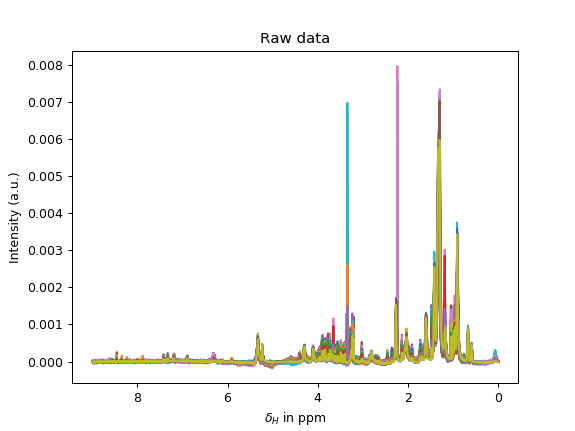

In [5]:
plt.figure()
plt.plot(ppm, X.T)
plt.title("Raw data")
plt.xlabel("$\delta_H$ in ppm")
plt.ylabel("Intensity (a.u.)")
plt.gca().invert_xaxis()
plt.show()

# Normalisation

The main purpose of normalisation is to account for systematic experimental differences in the overall intensity of observations (rows of the data matrix) that can confound the analysis. For example, different amount of material per sample, urinary dilution or an instrumental intensity drift caused by a batch or run-order effect. 

One of the first decisions in the statistical analysis of metabolic profile data is whether or not to apply 
normalisation, and which method to use. Mathematically, normalisation procedures estimate and apply an individual scaling factor to each observation in the data matrix (row-wise scaling of the data matrix).

Here we will demonstrate and use the Probabilistic Quotient Normalisation ([Dieterle et al. 2006](https://www.ncbi.nlm.nih.gov/pubmed/16808434)) method. 

The PQN algorithm requires the selection of reference spectrum. A robust default choice is to select the median or mean spectrum as normalisation reference.


<IPython.core.display.Javascript object>


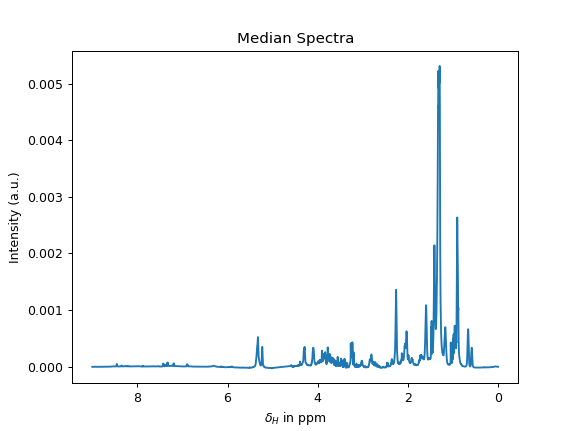

In [6]:
# Get reference median spectra
median_spectra = np.median(X, axis=0)

plt.figure()
plt.title("Median Spectra")
plt.xlabel("$\delta_H$ in ppm")
plt.ylabel("Intensity (a.u.)")
plt.plot(ppm, median_spectra)
plt.gca().invert_xaxis()
plt.show()

After selecting a reference, each data point (variable) in each observation (row) is divided by the corresponding value of the same variable in the reference, to obtain a matrix of ratios to reference (*foldChangeMatrix*). The PQN coefficients (*pqn_coef*) corresponding to each observation are then estimated by taking the median across all variables row-wise. These coefficients are then used to normalised the data.

In [7]:
# Calculate the ratio to the reference per variable for all spectrum, to obtain a matrix of "fold changes"
foldChangeMatrix = X / median_spectra[None, :]

# Estimate the median fold change per row (spectrum), which is the PQN normalisation coefficient. 
# We use the nanmedian function to automatically ignore NA's when estimating this factor
pqn_coef = np.nanmedian(foldChangeMatrix, axis=1)

# Normalise the spectra using the median ratio
norm_X = X / pqn_coef[:, None]


/home/gd2212/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in true_divide

/home/gd2212/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



We can now plot the PQN coefficients, to assess the range of overall intensity/dilution/concentration ranges in the dataset which will be corrected by the normalisation procedure. 

In the next histogram, these have been re-expressed as a scaling factor, $\frac{1}{PQN coefficient}$, for ease of interpretation: values smaller than one represent samples with an overall intensity higher than the median which will be downscaled, and the opposite for samples with value above 1.

<IPython.core.display.Javascript object>


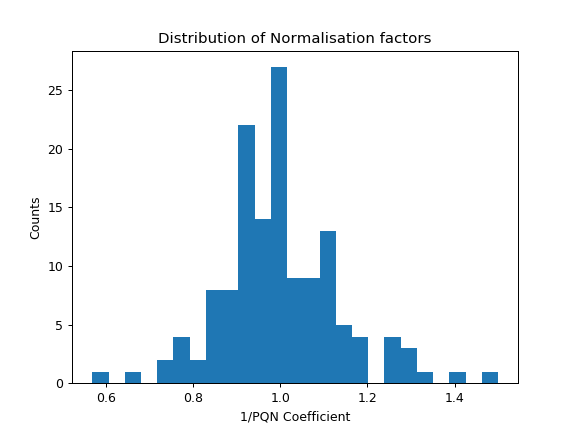

<IPython.core.display.Javascript object>


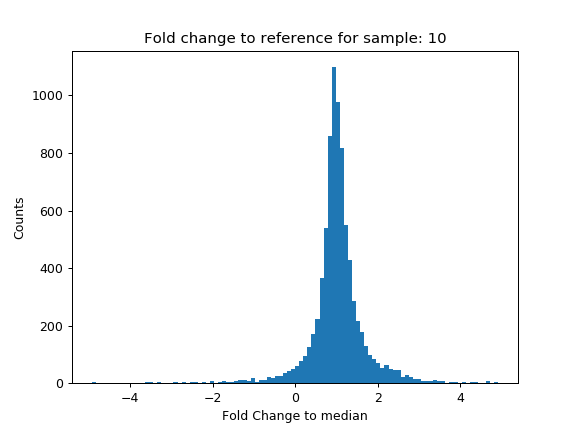

In [8]:
plt.figure()
plt.hist(1/pqn_coef, bins=25)
plt.xlabel("1/PQN Coefficient")
plt.ylabel('Counts')
plt.title("Distribution of Normalisation factors")
plt.show()

#Truncate extreme values to narrow histogram range
sample_to_plot = 10
idx_to_plot = ((foldChangeMatrix[sample_to_plot, :] <= 5) & (foldChangeMatrix[sample_to_plot, :] >= -5 ))


plt.figure()
plt.title('Fold change to reference for sample: {0}'.format(sample_to_plot))
plt.xlabel("Fold Change to median")
plt.ylabel("Counts")
plt.hist(foldChangeMatrix[sample_to_plot, idx_to_plot], bins=100)
plt.show()

We can now compare the original non-normalised data, plotted in blue, with the normalised spectra, in red.

<IPython.core.display.Javascript object>


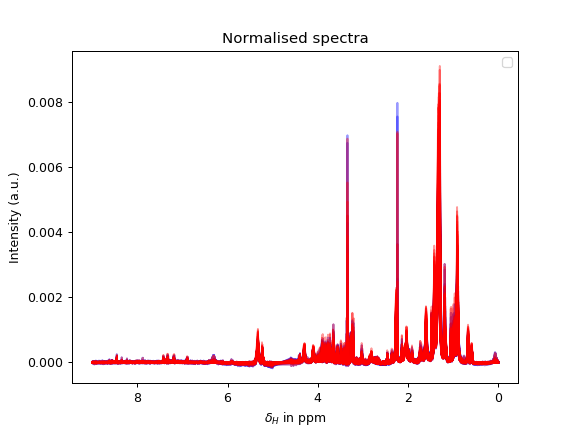

No handles with labels found to put in legend.


In [9]:
fig, ax = plt.subplots()
ax.plot(ppm, X.T,  c='b', alpha=0.4)
ax.plot(ppm, norm_X.T, c='r', alpha=0.4)
ax.set_title("Normalised spectra")
ax.set_xlabel("$\delta_H$ in ppm")
ax.set_ylabel("Intensity (a.u.)")
ax.invert_xaxis()
ax.legend()
plt.show()

np.savetxt('./data/X_norm.csv', norm_X, delimiter=',')

# Scaling

The choice of scaling is an important parameter choice when modelling the data with PCA and PLS regression algorithms. The scaling parameter impacts on the predictive performance of the model, the trends recovered from the data and model interpretation (i.e., loading vectors).

Scaling consists in dividing each variable (column of the data matrix) by a constant value. Variables with a higher intensity tend to have a higher variance. Since PCA and PLS maximize the recovery of variance and covariance, on non-scaled datasets the model will be biased towards features with higher signal intensity. Biologically, it is more reasonable to ensure all variables should be be given equal weight independent of their signal intensity. Scaling the data matrix can remove this bias and enhance recovery of important trends from lower intensity signals.

For more information about data scaling and transformation in metabolomics, we recommend [Berg et al. 2006](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1534033/)

The following 3 types of scaling choices are commonly used with multivariate PCA and PLS analyses:

Mean centring (MC) = $\frac{X - \mu}{\sigma^{0}}$, *scale_power* = 0. Mean centre all variables and apply no scaling.

Pareto scaling = $\frac{X - \mu}{\sigma^{1/2}}$, *scale_power* = 1/2. Mean centre all variables and divide each variable by the square root of its standard deviation ($\sigma$)

Unit variance (UV) scaling = $\frac{X - \mu}{\sigma^{1}}$, *scale_power* = 1. Mean center all variables and scale each variable by its standard deviation.


In the *pyChemometrics.ChemometricsScaler* objects we use the *scale_power* argument to represent the exponent of standard deviation used in scaling.

These three kinds of scaling are demonstrated below, followed by two other data transformation options, the logarithm and the square root transformation.


### 1) Mean-centring only (no scaling)

Removal of the column-wise mean from the data matrix (each variable is recentered around its own mean). Mean centring is usually suggested (although not a hard-requirement, the data). 

We will apply the different scaling methods using the *pyChemometrics.ChemometricsScaler* object. We start by initialising a *ChemometricsScaler* object. The *fit* method extracts the scaling parameters (mean and standard deviation vectors) from a data matrix, while the *transform* method takes a data matrix as input and applies to it the scaling using the parameters estimated when the *fit* method was last used.

In [10]:
mc_scaler = ChemometricsScaler(scale_power=0)
mc_scaler.fit(norm_X)
mc_X = mc_scaler.transform(norm_X)


In the next cell we plot the mean centred data matrix. The main features of the spectrum are still relatively easy to pinpoint (which will aid interpretation of multivariate parameters), but the wide range of values still means that higher intensity variables will dominate the analysis. This *penalises* the detection of trends in low intensity signals, which is not, but also ensures that spurious variation in noise peaks.

<IPython.core.display.Javascript object>


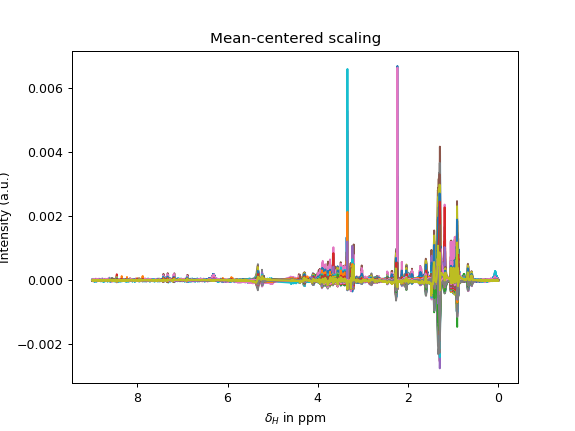

In [11]:
#mc_X = preprocessing.scale(norm_X, axis=0, with_mean=True, with_std=False)
plt.figure()
plt.plot(ppm, mc_X.T)
plt.xlabel("$\delta_H$ in ppm")
plt.ylabel("Intensity (a.u.)")
plt.title("Mean-centered scaling")
plt.gca().invert_xaxis()
plt.show()

### 2) Unit-variance (UV) scaling: Mean-centring followed by division of each variable (column) by its own standard deviation

The spectroscopic peaks and signals of the spectrum are now barely recognisable (difficult interpretation), but now the latent variables detected will not be biased towards variation in the high intensity variables, which biologically is a more reasonable criteria. Low intensity noise values are more likely to be picked up, including baseline artefacts, and the magnitude of most variables is now equalised, making it harder to recognise the spectral profile. 

In the next example we use the *fit_transform* method, which learns the scaling parameters and returns a scaled data matrix in one go.

In [12]:
uv_scaler = ChemometricsScaler(scale_power=1)
uv_X = uv_scaler.fit_transform(norm_X)


<IPython.core.display.Javascript object>


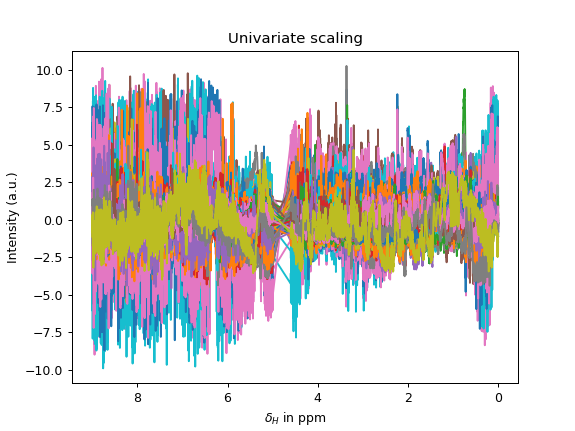

In [13]:
# Univariate and mean-centred
#uv_X = preprocessing.scale(norm_X, axis=0, with_mean=True, with_std=True)
plt.figure()
plt.plot(ppm, uv_X.T)
plt.title("Univariate scaling")
plt.xlabel("$\delta_H$ in ppm")
plt.ylabel("Intensity (a.u.)")
plt.gca().invert_xaxis()
plt.show()

### 3) Pareto scaling: Mean-centring followed by division of each variable (column) by the square root of its own standard deviation

Pareto scaling provides a balance between the mean centering (no scaling) and UV scaling.

In [14]:
par_scaler = ChemometricsScaler(scale_power=1/2)
pa_X = par_scaler.fit_transform(norm_X)

<IPython.core.display.Javascript object>


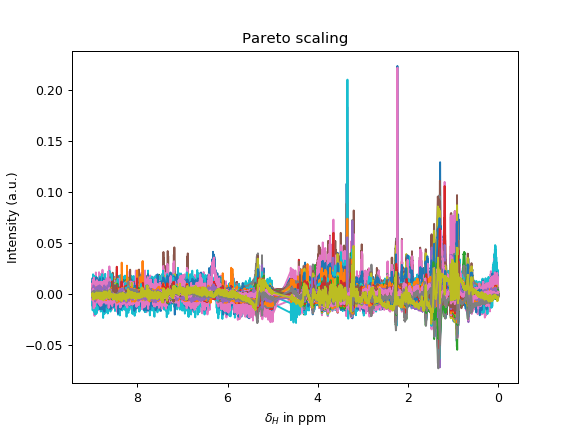

In [15]:
#std_dev_sq_root = np.sqrt(mc_X.std(axis=0))
#pa_X = mc_X / std_dev_sq_root

plt.figure()
plt.plot(ppm, pa_X.T)
plt.title("Pareto scaling")
plt.xlabel("$\delta_H$ in ppm")
plt.ylabel("Intensity (a.u.)")
plt.gca().invert_xaxis()
plt.show()

### 4) Logarithmic and square root transformation

Another option is apply non-linear transformations to the data matrix, such as the logarithmic transform and the square-root transformation. 

Log-transformation is a non-linear transformation, which has the advantage of removing the effect of heteroskedasticity between and within variables, when the coefficient of variation of the methods is constant (variance increasing with the mean). The scaling effect it has on variables is somewhat similar to Pareto scaling. They are also recommended for univariate analysis. 
These transformations functions are not defined for 0 values. To perform logarithmic transform  we first add an offset to ensure all data points are non-negative and non-zero. Here it is calculated by adding the minimum value in the dataset plus 1. Any offset or other transformation should be carefully recorded. 

Logarithmic and square-root transformations are not implemented in the *pyChemometrics.ChemometricsScaler* object, but can be applied by transforming the data as shown below. After applying these transformations, the data should still be mean centred before PCA and PLS modeling. 

<IPython.core.display.Javascript object>


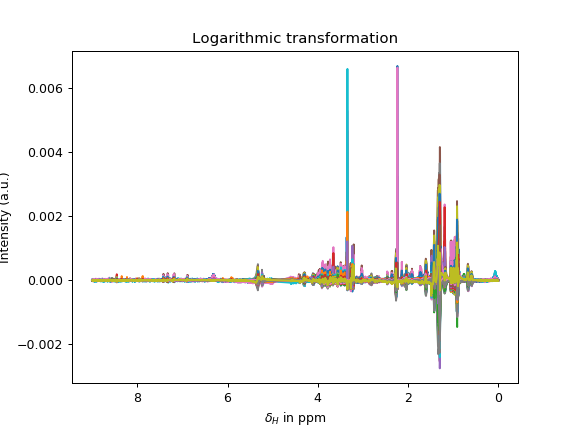

<IPython.core.display.Javascript object>


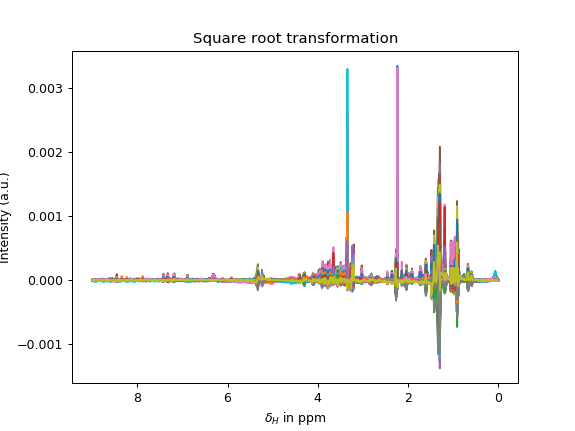

In [16]:
# Log scaling

# Offset is required to ensure all datapoints are non-negative and non-zero.
# Here it is being calculated by simply adding 1 
#to the minimum value in the dataset (to account for negative values in the noise region as well as 0).

offset = np.min(norm_X) + 1
log_X = np.log(norm_X + offset)
mean_logvec = np.mean(log_X, axis=0)
mclogX = (log_X - mean_logvec)

plt.figure()
plt.plot(ppm, mclogX.T)
plt.title("Logarithmic transformation")
plt.xlabel("$\delta_H$ in ppm")
plt.ylabel("Intensity (a.u.)")
plt.gca().invert_xaxis()
plt.show()

# Square root transformation

# Offset is required to ensure all datapoints are non-negative and non-zero.
# Here it is being calculated by simply adding 1 
#to the minimum value in the dataset (to account for negative values in the noise region as well as 0).

offset = np.min(norm_X) + 1
sqrt_X = np.sqrt(norm_X + offset)
mean_sqrvec = np.mean(sqrt_X, axis=0)
mcsqrt_X = (sqrt_X - mean_sqrvec)

plt.figure()
plt.plot(ppm, mcsqrt_X.T)
plt.title("Square root transformation")
plt.xlabel("$\delta_H$ in ppm")
plt.ylabel("Intensity (a.u.)")
plt.gca().invert_xaxis()
plt.show()

